In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from utils import Aircraft
import seaborn as sns
from labellines import labelLines

sns.set_palette('dark')

In [2]:
def digitiserData(data):
    dataX, dataY = zip(*[(float(datapoint.split(', ')[0]), float(datapoint.split(', ')[1])) for datapoint in data.split('; ')])
    return dataX, dataY

# International Standard Atmosphere

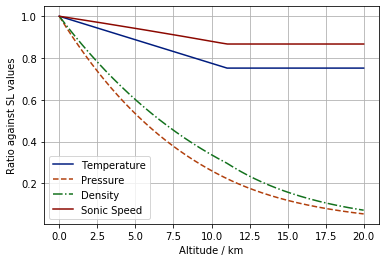

In [3]:
T_sl = 288.15
p_sl = 101325
rho_sl = 1.225
a_sl = 340.3

TRat = []
pRat = []
rhoRat = []
aRat = []

alts = np.arange(0,20,0.01)

for h in alts:
    if h <= 11:
        T = T_sl - 6.5*h
        TRat.append(T/T_sl)

        pRat.append((T/T_sl)**5.256)
        rhoRat.append((T/T_sl)**4.256)
        aRat.append((T/T_sl)**0.5)
    elif h <= 20:
        T = 216.65
        TRat.append(T/T_sl)

        tropRat = np.exp(-0.1577*(h-11))
        pRat.append(tropRat*22631/p_sl)
        rhoRat.append(tropRat*0.364/rho_sl)
        aRat.append((T/T_sl)**0.5)


plt.figure(figsize=[6,4])
plt.plot(alts, TRat, label='Temperature')
plt.plot(alts, pRat, label='Pressure', linestyle='--')
plt.plot(alts, rhoRat, label='Density', linestyle='-.')
plt.plot(alts, aRat, label='Sonic Speed')

plt.xlabel('Altitude / km')
plt.ylabel('Ratio against SL values')
plt.legend()
plt.grid()

plt.show()

In [4]:
def ISAh(h):
    hIdx = np.where(alts==h)[0][0]
    temperature = TRat[hIdx] * T_sl
    pressure = pRat[hIdx] * p_sl
    density = rhoRat[hIdx] * rho_sl
    soundSpeed = aRat[hIdx] * a_sl

    return temperature, pressure, density, soundSpeed

# Fitting to Humidity of Contrail Formation

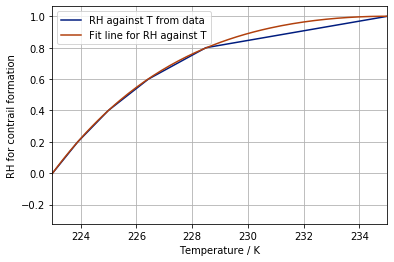

[-2.11945474e-05  1.99228746e-02 -7.02668394e+00  1.10205996e+03
 -6.48519007e+04]


In [88]:
def fitPoly(x,y,order,xFit):
    fitParams = np.polyfit(x, y, order)

    yFit = np.zeros(len(xFit))

    for i in range(order+1):
        yFit += fitParams[i]*xFit**(order-i)

    return yFit, fitParams

RHData = '235, 8.179797542997543; 228.4891891891892, 9.212033415233414; 226.42702702702704, 9.516202457002457; 224.98918918918918, 9.73348796068796; 223.8918918918919, 9.907349385749384; 222.9837837837838, 10.037692383292383'
TRHData,_ = digitiserData(RHData)
RHData = list(np.arange(1,-.1,-0.2))

TRHData = list(reversed(TRHData)) + [235*2-T for T in TRHData]
RHData = list(reversed(RHData)) + RHData

TFit = np.arange(222, 235.1, 0.1)
hFit = (288.15-TFit)/6.5
RHFit, fitParams = fitPoly(TRHData, RHData, 4, TFit)

ax1 = plt.figure(figsize=[6,4])
plt.plot(TRHData[:6], RHData[:6], label='RH against T from data')
plt.plot(TFit, RHFit, label='Fit line for RH against T')

plt.xlabel('Temperature / K')
plt.ylabel('RH for contrail formation')
plt.xlim([min(TRHData), max(TRHData[:6])])
plt.grid()
plt.legend()
plt.show()

print(fitParams)

# Optimise L/D with Mach number

In [6]:
aircraftSpecs = {'W_E':106_000, 'W_MP':40_000, 'W_MTO':220_000, 'W_P':40_000, 'W_F':74_000, # Weight specs
                'maxPass':240, 'MPRange':12_000, 'W_F_MP':74_000, 'SWing':315, # Other aircraft specs
                'rEgnine':45, 'thetEngine':6, 'effComp':0.9, 'effTurb':0.9, 'FPREngine':1.45, 'effFan':0.92, 'effTransfer':0.9, 'LCVFuel':42.7e6, # Engine
                'timestep':10, 'k':0.015, 'c1':0.3, 'c2':1.0, 'K1':0.0125, 'K2':0.0446, 'vRat':1, 'dontCheckMach':False, 'dontCheckW_P':False} # Model parameters

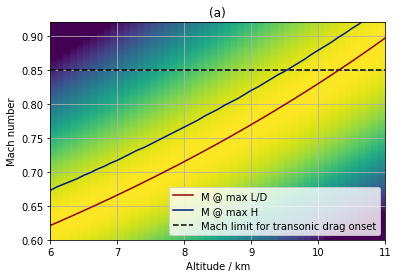

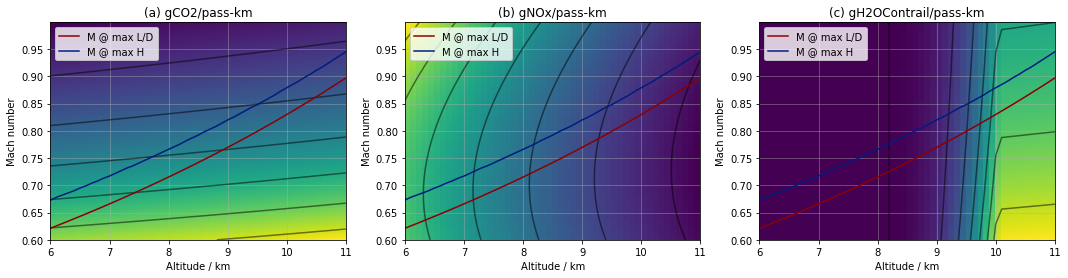

In [90]:
MRange = np.arange(0.6,1,0.001)
hRange = np.arange(6,11.1,0.1)
MLDMax = []
MHMax = []
LDMesh = np.zeros((len(hRange), len(MRange)))
W_CO2Mesh = np.zeros((len(hRange), len(MRange)))
W_NOxMesh = np.zeros((len(hRange), len(MRange)))
W_H2OMesh = np.zeros((len(hRange), len(MRange)))

for i, h in enumerate(hRange):
    LDs = []
    products = []
    Ms = []

    for j, M in enumerate(MRange):
        aircraft = Aircraft(aircraftSpecs)
        aircraft.dontCheckMach = True
        aircraft.updateAllFlightValues(h, MOvrd=M, ft=False)
        LDs.append(1/aircraft.beta)
        products.append(LDs[-1] * aircraft.effOverall)
        Ms.append(aircraft.M)

        aircraft.updateAllFlightValues(h, MOvrd=M, ft=False)
        W_CO2Mesh[i,j] = aircraft.W_CO2 / aircraft.s
        W_NOxMesh[i,j] = aircraft.W_NOX / aircraft.s
        W_H2OMesh[i,j] = aircraft.W_H2OContrail / aircraft.s

    LDMesh[i,:] = LDs
    MLDMax.append(aircraft.EASOpt/(aircraft.rho/aircraft.rho_sl)**0.5/aircraft.a)
    MHMax.append(Ms[products.index(max(products))])

plt.figure(figsize=[6,4])

MMesh, hMesh = np.meshgrid(MRange, hRange)

plt.pcolormesh(hMesh, MMesh, LDMesh, vmin=np.min(LDMesh)+3)
plt.plot(hRange, MLDMax, color='darkred', label='M @ max L/D')
plt.plot(hRange, MHMax, label='M @ max H')

plt.hlines(0.85, min(hRange), max(hRange), linestyle='--', color='black', label='Mach limit for transonic drag onset')

plt.title('(a)')
plt.xlabel('Altitude / km')
plt.ylabel('Mach number')
plt.ylim([0.6, 0.92])
plt.yticks(np.arange(0.6, 0.9, 0.05))
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Emissions
plt.figure(figsize=[18,4])

plt.subplot(1,3,1)
plt.pcolormesh(hMesh, MMesh, W_CO2Mesh)
plt.contour(hMesh, MMesh, W_CO2Mesh, colors='black', alpha=0.5)
plt.plot(hRange, MLDMax, color='darkred', label='M @ max L/D')
plt.plot(hRange, MHMax, label='M @ max H')
plt.xlabel('Altitude / km')
plt.ylabel('Mach number')
plt.title('(a) gCO2/pass-km')
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1,3,2)
plt.pcolormesh(hMesh, MMesh, W_NOxMesh)
plt.contour(hMesh, MMesh, W_NOxMesh, colors='black', alpha=0.5)
plt.plot(hRange, MLDMax, color='darkred', label='M @ max L/D')
plt.plot(hRange, MHMax, label='M @ max H')
plt.xlabel('Altitude / km')
plt.ylabel('Mach number')
plt.title('(b) gNOx/pass-km')
plt.grid(alpha=0.5)
plt.legend()

plt.subplot(1,3,3)
plt.pcolormesh(hMesh, MMesh, W_H2OMesh)
plt.contour(hMesh, MMesh, W_H2OMesh, colors='black', alpha=0.5)
plt.plot(hRange, MLDMax, color='darkred', label='M @ max L/D')
plt.plot(hRange, MHMax, label='M @ max H')
plt.xlabel('Altitude / km')
plt.ylabel('Mach number')
plt.title('(c) gH2OContrail/pass-km')
plt.grid(alpha=0.5)
plt.legend()

plt.show()

2.4506043539544704


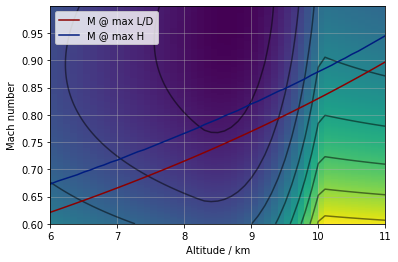

In [101]:
W_CO2Mesh = W_CO2Mesh / np.max(W_CO2Mesh[:,:])
W_NOxMesh = W_NOxMesh / np.max(W_NOxMesh[:,:])
W_H2OMesh = W_H2OMesh / np.max(W_H2OMesh[:,:])

W_PolComb = W_CO2Mesh + W_NOxMesh + W_H2OMesh
print(np.max(W_PolComb))

plt.pcolormesh(hMesh, MMesh, W_PolComb)
plt.contour(hMesh, MMesh, W_PolComb, colors='black', alpha=0.5)
plt.plot(hRange, MLDMax, color='darkred', label='M @ max L/D')
plt.plot(hRange, MHMax, label='M @ max H')
plt.xlabel('Altitude / km')
plt.ylabel('Mach number')
plt.grid(alpha=0.5)
plt.legend()

plt.show()

[1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002,

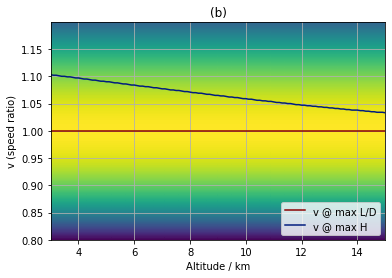

In [58]:
vRange = np.arange(0.8,1.2,0.001)
hRangeOptv = np.arange(3,15.1,0.1)
vLDMax = []
vHMax = []
LDMesh = np.zeros((len(hRangeOptv), len(MRange)))

for i, h in enumerate(hRangeOptv):
    LDs = []
    products = []

    for j, v in enumerate(vRange):
        aircraft = Aircraft(aircraftSpecs)
        aircraft.vRat = v
        aircraft.dontCheckMach = True
        aircraft.updateAllFlightValues(h, ft=False)
        LDs.append(1/aircraft.beta)
        products.append(LDs[-1] * aircraft.effOverall)

    LDMesh[i,:] = LDs
    vLDMax.append(vRange[LDs.index(max(LDs))])
    vHMax.append(vRange[products.index(max(products))])

print(vLDMax)
print(vHMax)
plt.figure(figsize=[6,4])

vMesh, hMesh = np.meshgrid(vRange, hRangeOptv)

plt.pcolormesh(hMesh, vMesh, LDMesh)
plt.plot(hRangeOptv, vLDMax, color='darkred', label='v @ max L/D')
plt.plot(hRangeOptv, vHMax, label='v @ max H')

plt.title('(b)')
plt.xlabel('Altitude / km')
plt.ylabel('v (speed ratio)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Effect of speed ratio on L/D and overall efficiency

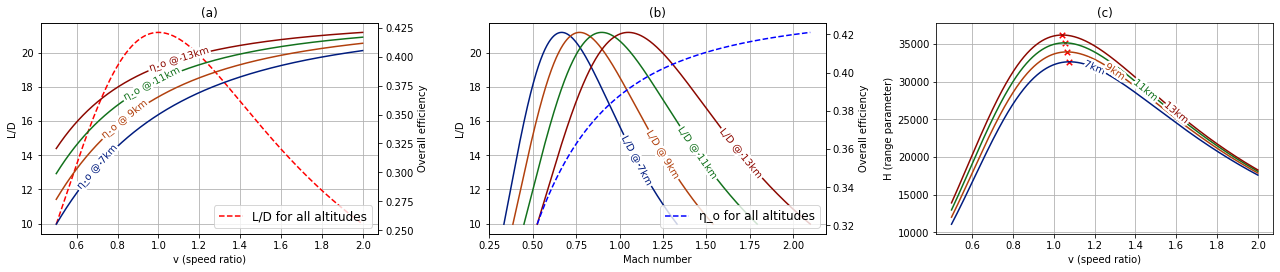

In [10]:
altitudes = np.arange(7,14,2)
vRatRange = np.arange(0.5, 2, 0.001)


fig = plt.figure(figsize=[18,4])
ax1 = fig.add_subplot(131)
ax2 = ax1.twinx()
ax3 = fig.add_subplot(132)
ax4 = ax3.twinx()
ax5 = fig.add_subplot(133)

for i, h in enumerate(altitudes):
    LDs, effs, Ms, Hs = [],[],[], []
    for j, vRat in enumerate(vRatRange):
        aircraft = Aircraft(aircraftSpecs)
        aircraft.dontCheckMach = True
        aircraft.vRat = vRat

        aircraft.updateAllFlightValues(h, ft=False)

        LDs.append(1/aircraft.beta)
        effs.append(aircraft.effOverall)
        Ms.append(aircraft.M)
        Hs.append(42700*LDs[-1]*effs[-1]/9.81)

    ax2.plot(vRatRange, effs, label=f'η_o @ {h}km')
    ax3.plot(Ms, LDs, label=f'L/D @ {h}km')
    ax5.plot(vRatRange, Hs, label=f'{h}km')
    maxHIdx = Hs.index(max(Hs))
    ax5.scatter(vRatRange[maxHIdx], Hs[maxHIdx], marker='x', color='red', s=30)

ax1.plot(vRatRange, LDs, color='red', linestyle='--', label='L/D for all altitudes')
ax4.plot(Ms, effs, color='blue', linestyle='--', label=f'η_o for all altitudes')

ax1.legend(loc='lower right', fontsize=12)
ax1.set_xlabel('v (speed ratio)')
ax1.set_ylabel('L/D')
ax2.set_ylabel('Overall efficiency')

ax4.legend(loc='lower right', fontsize=12)
ax3.set_xlabel('Mach number')
ax3.set_ylabel('L/D')
ax4.set_ylabel('Overall efficiency')

xLabels = np.linspace(0.7, 1.1, 4)
lines = ax2.get_lines()
labelLines(lines, drop_label=True, align=True, xvals=xLabels)
ax1.grid()

xLabels = [1.1,1.25,1.45,1.7]
lines = ax3.get_lines()
labelLines(lines, drop_label=True, align=True, xvals=xLabels)
ax3.grid()

ax5.set_xlabel('v (speed ratio)')
ax5.set_ylabel('H (range parameter)')
xLabels = [1.2,1.3,1.45,1.6]
lines = ax5.get_lines()
labelLines(lines, drop_label=True, align=True, xvals=xLabels)
ax5.grid()

ax1.set_title('(a)')
ax3.set_title('(b)')
ax5.set_title('(c)')

fig.tight_layout(pad=1.5)
plt.show()

In [11]:
def findOptimalSpeedRatio(h):
    vRatRange = np.arange(0.9, 1.3, 0.001)

    LDs = np.zeros(len(vRatRange))
    effs = np.zeros(len(vRatRange))

    for i, vRat in enumerate(vRatRange):
        aircraft = Aircraft(aircraftSpecs)
        aircraft.dontCheckMach = True
        aircraft.vRat = vRat

        aircraft.updateAllFlightValues(h, ft=False)

        LDs[i] = 1/aircraft.beta
        effs[i] = aircraft.effOverall
        
    Hs = 42700*LDs*effs/9.81

    maxH = max(Hs)

    return round(vRatRange[np.where(Hs==maxH)[0][0]],3)

# Constant altitude constant Mach flight

In [185]:
def simulateFlight(aircraftSpecs, altitudes, M=-1):
    aircraft = Aircraft(aircraftSpecs)

    timeData = {'distances':[],
    'times':[],
    'altitudes':[],
    'fuelBurns':[],
    'machs':[],
    'vRats':[],
    'Hs':[],
    'LDRats':[],
    'weights':[],
    'effOveralls':[],
    'effCycles':[],
    'effProps':[],
    'W_CO2s':[],
    'W_NOXs':[],
    'W_H2Os':[],
    'cumContrailChances':[],
    'W_H2OContrails':[]}
    
    distance = 0.0
    altIdx = 0

    while aircraft.W_F > 0:
        if distance > altitudes[altIdx+1, 0]:
            # If distance for next stage in altitude sequence has been reached
            altIdx += 1
        alt = altitudes[altIdx, 1]
        
        aircraft.updateAllFlightValues(alt, ft=False, MOvrd=M)

        distance = aircraft.s/1000
        timeData['distances'].append(distance)
        timeData['times'].append(aircraft.time)
        timeData['altitudes'].append(aircraft.h)
        timeData['fuelBurns'].append(aircraft.W_FB/1000)
        timeData['machs'].append(aircraft.M)
        timeData['vRats'].append(aircraft.vRat)
        timeData['Hs'].append(aircraft.H/1000)
        timeData['LDRats'].append(1/aircraft.beta)
        timeData['weights'].append(aircraft.W)
        timeData['effOveralls'].append(aircraft.effOverall)
        timeData['effCycles'].append(aircraft.effCycle)
        timeData['effProps'].append(aircraft.effProp)
        timeData['W_CO2s'].append(aircraft.W_CO2)
        timeData['W_NOXs'].append(aircraft.W_NOX)
        timeData['W_H2Os'].append(aircraft.W_H2O)
        timeData['cumContrailChances'].append(aircraft.cumContrailChance)
        timeData['W_H2OContrails'].append(aircraft.W_H2OContrail)

    gCO2PPKM = timeData['W_CO2s'][-1]/(240*timeData['distances'][-1])
    gNOxPPKM = timeData['W_NOXs'][-1]/(240*timeData['distances'][-1])
    gH2OPPKM = timeData['W_H2OContrails'][-1]/(240*timeData['distances'][-1])
    avgContrailChance = timeData['cumContrailChances'][-1]*100/timeData['distances'][-1]
    
    timeData['timeTo12000'] = timeData['times'][np.where(np.array(timeData['distances']) > 12000)[0][0]]

    if M!=-1:
        print(f"M = {M:.2f} | Start altitude: {altitudes[0,1]:.2f} | Distance flown: {timeData['distances'][-1]:.0f} km | CO2 pollution: {gCO2PPKM:.2f} g/passkm | NOx pollution: {gNOxPPKM:.2f} g/passkm | \
H2O contrail pollution: {gH2OPPKM:.2f} g/passkm | Avg contrail chance = {avgContrailChance:.2f} % | Time of flight: {timeData['timeTo12000']/3600:.2f} hours | Number of iterations: {len(timeData['distances'])}")
    else:
        print(f"v = {aircraftSpecs['vRat']:.3f} | Start altitude: {altitudes[0,1]:.2f} | Distance flown: {timeData['distances'][-1]:.0f} km | CO2 pollution: {gCO2PPKM:.2f} g/passkm | NOx pollution: {gNOxPPKM:.2f} g/passkm | \
H2O contrail pollution: {gH2OPPKM:.2f} g/passkm | Avg contrail chance = {avgContrailChance:.2f} % | Time of flight: {timeData['timeTo12000']/3600:.2f} hours | Number of iterations: {len(timeData['distances'])}")

    return timeData

M = 0.85 | Start altitude: 9.50 | Distance flown: 12899 km | CO2 pollution: 73.82 g/passkm | NOx pollution: 2.20 g/passkm | H2O contrail pollution: 13.61 g/passkm | Avg contrail chance = 15.63 % | Time of flight: 13.01 hours | Number of iterations: 5032
v = 1.000 | Start altitude: 9.50 | Distance flown: 13067 km | CO2 pollution: 72.87 g/passkm | NOx pollution: 1.82 g/passkm | H2O contrail pollution: 13.44 g/passkm | Avg contrail chance = 18.37 % | Time of flight: 15.15 hours | Number of iterations: 5989
9.5 9.5 0.799 0.6558
v = 1.062 | Start altitude: 9.50 | Distance flown: 13195 km | CO2 pollution: 72.17 g/passkm | NOx pollution: 1.93 g/passkm | H2O contrail pollution: 13.31 g/passkm | Avg contrail chance = 17.29 % | Time of flight: 14.26 hours | Number of iterations: 5695
9.5 9.5 0.8486 0.6965


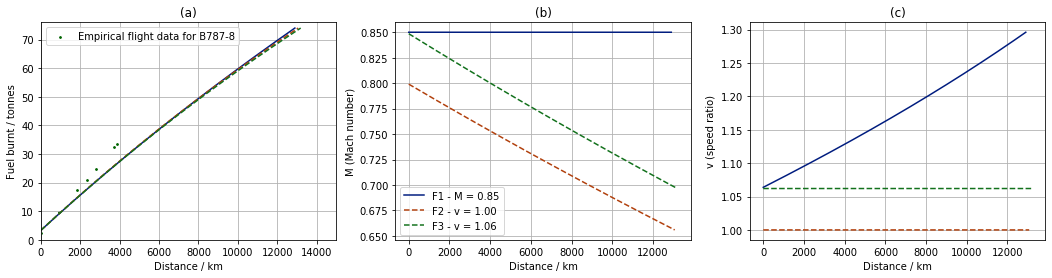

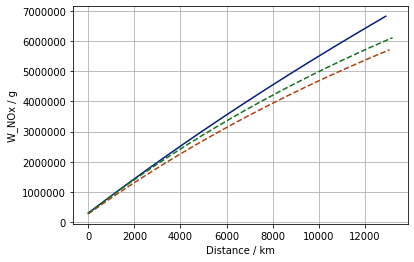

In [324]:
fuelBurnData = '-13.779527559055055, 2508.960573476652; 930.1181102362204, 9677.419354838668; 1860.236220472441, 17275.985663082407; 2321.850393700787, 21003.584229390646; 2790.354330708661, 24587.81362007164; 3727.36220472441, 32329.749103942624; 3861.712598425197, 33548.38709677418'
notesSFB, notesFB = digitiserData(fuelBurnData)
notesFB = np.array(notesFB)/1000

plt.figure(figsize=[18,4])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

fig = plt.figure()
ax4 = fig.add_subplot(111)

# Plot fuel burn at constant Mach numbers
timeData = simulateFlight(aircraftSpecs, np.array([[0,9.5],[20000,0]]), M=0.85)
ax1.plot(timeData['distances'], timeData['fuelBurns'])
ax2.plot(timeData['distances'], timeData['machs'], label='F1 - M = 0.85')
ax3.plot(timeData['distances'], timeData['vRats'])
ax4.plot(timeData['distances'], timeData['W_NOXs'])

# Empirical data
ax1.scatter(notesSFB, notesFB, s=3, color='darkgreen', label='Empirical flight data for B787-8')

# vRat flight
timeData = simulateFlight(aircraftSpecs, np.array([[0,9.5],[20000,0]]))

print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))

ax1.plot(timeData['distances'], timeData['fuelBurns'], linestyle='--')
ax2.plot(timeData['distances'], timeData['machs'], label='F2 - v = 1.00', linestyle='--')
ax3.plot(timeData['distances'], timeData['vRats'], linestyle='--')
ax4.plot(timeData['distances'], timeData['W_NOXs'], linestyle='--')

vRat = vHMax[np.where(np.round(hRangeOptv,1)==9.5)[0][0]]
aircraftSpecs['vRat'] = vRat
timeData = simulateFlight(aircraftSpecs, np.array([[0,9.5],[20000,0]]))
aircraftSpecs['vRat'] = 1

print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))

ax1.plot(timeData['distances'], timeData['fuelBurns'], linestyle='--')
ax2.plot(timeData['distances'], timeData['machs'], label=f'F3 - v = {vRat:.2f}', linestyle='--')
ax3.plot(timeData['distances'], timeData['vRats'], linestyle='--')
ax4.plot(timeData['distances'], timeData['W_NOXs'], linestyle='--')

ax1.set_title('(a)')
ax1.set_xlabel('Distance / km')
ax1.set_ylabel('Fuel burnt / tonnes')
ax1.set_xlim([0,15000])
ax1.set_ylim([0,76])
ax1.grid()
ax1.legend()

ax2.set_title('(b)')
ax2.set_xlabel('Distance / km')
ax2.set_ylabel('M (Mach number)')
ax2.grid()
ax2.legend()

ax3.set_title('(c)')
ax3.set_xlabel('Distance / km')
ax3.set_ylabel('v (speed ratio)')
ax3.grid()

ax4.set_xlabel('Distance / km')
ax4.set_ylabel('W_NOx / g')
ax4.grid()

plt.show()



# Speed ratio and step climb flight

In [273]:
def findAlt4CruiseMach(vRat, MCruise, W_F=-1, W_E=-1, W_P=-1):
    if W_F != -1:
        W = (W_E + W_P + W_F)*0.985
    else:
        W = 220000*0.985
    
    betaOpt = 1/21.176

    beta = 0.5 * betaOpt * (vRat**2 + 1/vRat**2)

    if vRat<1:
        Cl = (beta + (beta**2 - 4*0.0446*0.0125)**0.5) / (2*0.0446)
    else:
        Cl = (beta - (beta**2 - 4*0.0446*0.0125)**0.5) / (2*0.0446)

    pRatio = 2*W*9.81 / (p_sl * Cl * 1.4 * MCruise**2 * 315)

    diffP = [abs(p - pRatio) for p in pRat]

    idx = diffP.index(min(diffP))

    h = alts[idx]

    return h

In [326]:
def simulateSteppedCruise(aircraftSpecs, startAlt, climbMachThresh, climbAlt, limitAlt=-1, suppressStats=False):
    aircraft = Aircraft(aircraftSpecs)
    aircraft.dontCheckMach = True
    alt = startAlt

    timeData = {'distances':[],
    'altitudes':[],
    'times':[],
    'fuelBurns':[],
    'machs':[],
    'vRats':[],
    'Hs':[],
    'LDRats':[],
    'weights':[],
    'effOveralls':[],
    'effCycles':[],
    'effProps':[],
    'W_CO2s':[],
    'W_NOXs':[],
    'W_H2Os':[],
    'cumContrailChances':[],
    'W_H2OContrails':[]}

    while aircraft.W_F > 0:
        aircraft.updateAllFlightValues(alt, ft=False)

        distance = aircraft.s/1000
        timeData['distances'].append(distance)
        timeData['altitudes'].append(aircraft.h)
        timeData['times'].append(aircraft.time)
        timeData['fuelBurns'].append(aircraft.W_FB/1000)
        timeData['machs'].append(aircraft.M)
        timeData['vRats'].append(aircraft.vRat)
        timeData['Hs'].append(aircraft.H/1000)
        timeData['LDRats'].append(1/aircraft.beta)
        timeData['weights'].append(aircraft.W)
        timeData['effOveralls'].append(aircraft.effOverall)
        timeData['effCycles'].append(aircraft.effCycle)
        timeData['effProps'].append(aircraft.effProp)
        timeData['W_CO2s'].append(aircraft.W_CO2)
        timeData['W_NOXs'].append(aircraft.W_NOX)
        timeData['W_H2Os'].append(aircraft.W_H2O)
        timeData['cumContrailChances'].append(aircraft.cumContrailChance)
        timeData['W_H2OContrails'].append(aircraft.W_H2OContrail)

        if timeData['machs'][-1] < climbMachThresh:
            alt += climbAlt
            if limitAlt!=-1 and alt > limitAlt:
                alt = limitAlt
            # aircraft.vRat = vHMax[np.where(np.round(hRangeOptv,1)==round(alt,1))[0][0]]
        
    timeData['gCO2PPKM'] = timeData['W_CO2s'][-1]/(240*timeData['distances'][-1])
    timeData['gNOxPPKM'] = timeData['W_NOXs'][-1]/(240*timeData['distances'][-1])
    timeData['gH2OPPKM'] = timeData['W_H2OContrails'][-1]/(240*timeData['distances'][-1])
    timeData['avgContrailChance'] = timeData['cumContrailChances'][-1]*100/timeData['distances'][-1]
    if timeData['distances'][-1] > 12000:
        timeData['timeTo12000'] = timeData['times'][np.where(np.array(timeData['distances']) > 12000)[0][0]]
    else:
        timeData['timeTo12000'] = timeData['times'][-1]/timeData['distances'][-1] * 12000
    
    if suppressStats==False:
        print(f"v = {timeData['vRats'][0]:.3f} | Start altitude: {startAlt:.2f} | Distance flown: {timeData['distances'][-1]:.0f} km | CO2 pollution: {timeData['gCO2PPKM']:.2f} g/passkm | NOx pollution: {timeData['gNOxPPKM']:.2f} g/passkm | \
H2O contrail pollution: {timeData['gH2OPPKM']:.2f} g/passkm | Avg contrail chance = {timeData['avgContrailChance']:.2f} % | Time to 12000: {timeData['timeTo12000']/3600:.2f} hours | Number of iterations: {len(timeData['distances'])}")
        
    return timeData

v=1.062 flight
v = 1.062 | Start altitude: 9.50 | Distance flown: 13195 km | CO2 pollution: 72.17 g/passkm | NOx pollution: 1.93 g/passkm | H2O contrail pollution: 13.31 g/passkm | Avg contrail chance = 17.29 % | Time to 12000: 14.26 hours | Number of iterations: 5695
v=1 flight with 3-step climb
v = 1.000 | Start altitude: 10.28 | Distance flown: 13553 km | CO2 pollution: 70.26 g/passkm | NOx pollution: 1.66 g/passkm | H2O contrail pollution: 32.33 g/passkm | Avg contrail chance = 40.83 % | Time to 12000: 13.57 hours | Number of iterations: 5533
10.28 12.08 0.848 0.8016
v=1 flight with 7-step climb
v = 1.000 | Start altitude: 10.28 | Distance flown: 13598 km | CO2 pollution: 70.03 g/passkm | NOx pollution: 1.67 g/passkm | H2O contrail pollution: 32.22 g/passkm | Avg contrail chance = 40.32 % | Time to 12000: 13.42 hours | Number of iterations: 5483
10.28 12.38 0.848 0.8208


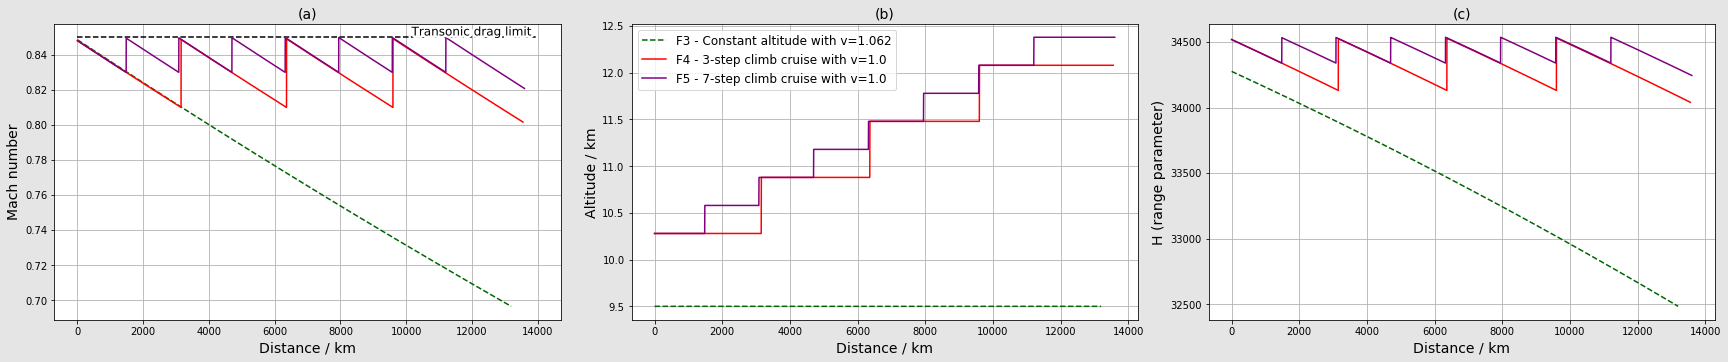

In [327]:
# Plot the Mach number following a speed ratio for different altitudes
fig = plt.figure(figsize=[24,5])
fig.set_facecolor('#E5E5E5')

ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)


ax1.plot([0,14000],[0.85, 0.85], label='Transonic drag limit', color='black', linestyle='--')
lines = ax1.get_lines()
labelLines(lines, drop_label=True, align=True, xvals=[12000], yoffsets=[0.003], fontsize=12)

print('v=1.062 flight')
hStart = findAlt4CruiseMach(1.062, 0.85)
aircraftSpecs['vRat'] = 1.062
timeData = simulateSteppedCruise(aircraftSpecs, 9.5, 0, 0.6, limitAlt=hStart+3*0.6)
aircraftSpecs['vRat'] = 1
ax1.plot(timeData['distances'], timeData['machs'], color='darkgreen', linestyle='--')
ax2.plot(timeData['distances'], timeData['altitudes'], color='darkgreen', linestyle='--', label='F3 - Constant altitude with v=1.062')
ax3.plot(timeData['distances'], timeData['Hs'], color='darkgreen', linestyle='--')

print('v=1 flight with 3-step climb')
hStart = findAlt4CruiseMach(1, 0.85)
timeData = simulateSteppedCruise(aircraftSpecs, hStart, 0.81, 0.6, limitAlt=hStart+3*0.6)
print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))
ax1.plot(timeData['distances'], timeData['machs'], color='red')
ax2.plot(timeData['distances'], timeData['altitudes'], color='red', label='F4 - 3-step climb cruise with v=1.0')
ax3.plot(timeData['distances'], timeData['Hs'], color='red')

print('v=1 flight with 7-step climb')
timeData = simulateSteppedCruise(aircraftSpecs, hStart, 0.83, 0.3, limitAlt=hStart+7*0.3)
print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))
ax1.plot(timeData['distances'], timeData['machs'], color='purple')
ax2.plot(timeData['distances'], timeData['altitudes'], color='purple', label='F5 - 7-step climb cruise with v=1.0')
ax3.plot(timeData['distances'], timeData['Hs'], color='purple')

ax1.set_title('(a)', fontsize=14)
ax1.set_xlabel('Distance / km', fontsize=14)
ax1.set_ylabel('Mach number', fontsize=14)
ax1.grid()

ax2.set_title('(b)', fontsize=14)
ax2.set_xlabel('Distance / km', fontsize=14)
ax2.set_ylabel('Altitude / km', fontsize=14)
ax2.grid()
ax2.legend(fontsize=12)

ax3.set_title('(c)', fontsize=14)
ax3.set_xlabel('Distance / km', fontsize=14)
ax3.set_ylabel('H (range parameter)', fontsize=14)
ax3.grid()

fig.tight_layout(pad=0.6)
plt.show()

# Continuous climb flight

v=1 flight with 7-step climb
v = 1.000 | Start altitude: 10.28 | Distance flown: 13598 km | CO2 pollution: 70.03 g/passkm | NOx pollution: 1.67 g/passkm | H2O contrail pollution: 32.22 g/passkm | Avg contrail chance = 40.32 % | Time to 12000: 13.42 hours | Number of iterations: 5483
10.28 12.38 0.848 0.8208
Continuous climb cruise
v = 1.000 | Start altitude: 10.28 | Distance flown: 13639 km | CO2 pollution: 69.81 g/passkm | NOx pollution: 1.67 g/passkm | H2O contrail pollution: 32.12 g/passkm | Avg contrail chance = 39.83 % | Time to 12000: 13.28 hours | Number of iterations: 5432
10.28 12.822 0.848 0.8499


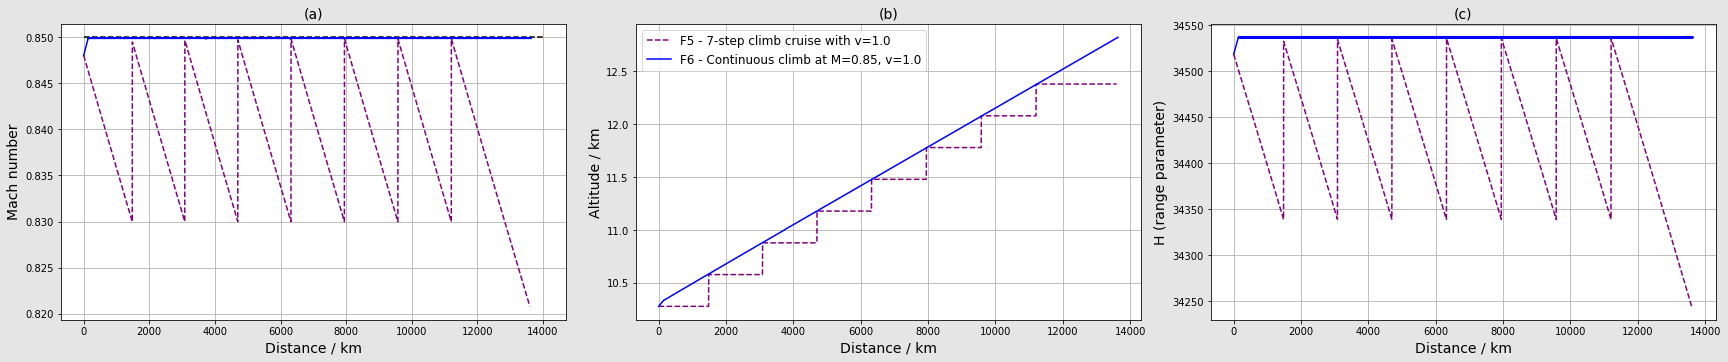

In [328]:
# Plot the Mach number following a speed ratio for different altitudes
fig = plt.figure(figsize=[24,5])
fig.set_facecolor('#E5E5E5')
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)


ax1.plot([0,14000],[0.85, 0.85], label='Transonic drag limit', color='black', linestyle='--')
lines = ax1.get_lines()
labelLines(lines, drop_label=True, align=True, xvals=[12000], yoffsets=[0.003], fontsize=12)

print('v=1 flight with 7-step climb')
timeData = simulateSteppedCruise(aircraftSpecs, hStart, 0.83, 0.3, limitAlt=hStart+7*0.3)
print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))
ax1.plot(timeData['distances'], timeData['machs'], color='purple', linestyle='--')
ax2.plot(timeData['distances'], timeData['altitudes'], color='purple', linestyle='--', label='F5 - 7-step climb cruise with v=1.0')
ax3.plot(timeData['distances'], timeData['Hs'], color='purple', linestyle='--')

print('Continuous climb cruise')
timeData = simulateSteppedCruise(aircraftSpecs, hStart, 0.8499, 0.001)
print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))
ax1.plot(timeData['distances'], timeData['machs'], color='blue')
ax2.plot(timeData['distances'], timeData['altitudes'], color='blue', label='F6 - Continuous climb at M=0.85, v=1.0')
ax3.plot(timeData['distances'], timeData['Hs'], color='blue')

ax1.set_title('(a)', fontsize=14)
ax1.set_xlabel('Distance / km', fontsize=14)
ax1.set_ylabel('Mach number', fontsize=14)
ax1.grid()

ax2.set_title('(b)', fontsize=14)
ax2.set_xlabel('Distance / km', fontsize=14)
ax2.set_ylabel('Altitude / km', fontsize=14)
ax2.grid()
ax2.legend(fontsize=12)

ax3.set_title('(c)', fontsize=14)
ax3.set_xlabel('Distance / km', fontsize=14)
ax3.set_ylabel('H (range parameter)', fontsize=14)
ax3.grid()

fig.tight_layout(pad=0.6)
plt.show()

# Effect of v on range and pollution

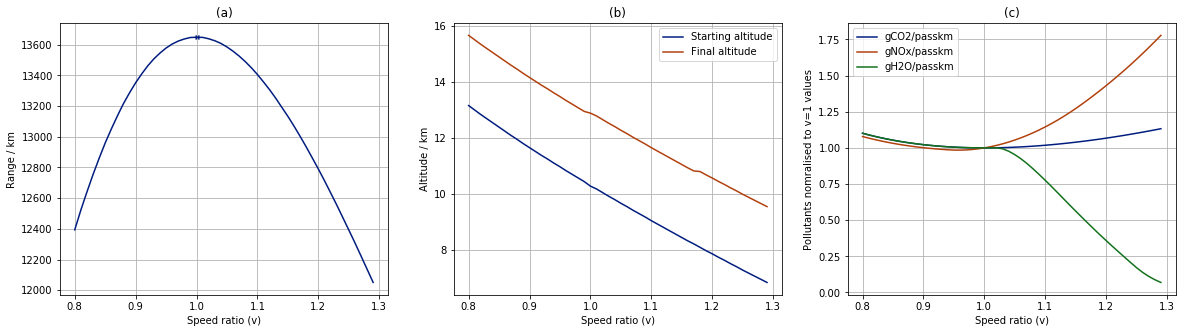

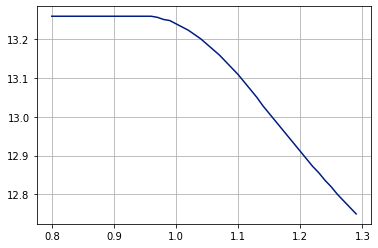

In [278]:
# Stepped cruise with different speed ratios
vRatRange = np.arange(0.8,1.3,0.01)
totDists = []
avgHs = []
gCO2PPKMs = []
gNOxPPKMs = []
gH2OPPKMs = []
startAlts = []
finalAlts = []
flightTimes = []

# Baseline figures at vRat = 1
hStart = findAlt4CruiseMach(1, 0.85)
timeData = simulateSteppedCruise(aircraftSpecs, hStart, 0.849, 0.1, suppressStats=True)
gCO2PPKM_base = timeData['gCO2PPKM']
gNOxPPKM_base = timeData['gNOxPPKM']
gH2OPPKM_base = timeData['gH2OPPKM']


plt.figure(figsize=[20,5])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

for vRat in vRatRange:
    hStart = findAlt4CruiseMach(vRat, 0.85)
    aircraftSpecs['vRat'] = vRat
    timeData = simulateSteppedCruise(aircraftSpecs, hStart, 0.849, 0.1, suppressStats=True)
    aircraftSpecs['vRat'] = 1

    totDists.append(timeData['distances'][-1])
    avgHs.append(np.mean(timeData['Hs']))
    gCO2PPKMs.append(timeData['gCO2PPKM'] / gCO2PPKM_base)
    gNOxPPKMs.append(timeData['gNOxPPKM'] / gNOxPPKM_base)
    gH2OPPKMs.append(timeData['gH2OPPKM'] / gH2OPPKM_base)
    startAlts.append(timeData['altitudes'][0])
    finalAlts.append(timeData['altitudes'][-1])
    flightTimes.append(timeData['timeTo12000']/3600)


ax1.plot(vRatRange, totDists)
ax1.scatter(round(vRatRange[totDists.index(max(totDists))], 3), round(max(totDists), 3), marker='x', s=15)

ax1.set_title('(a)')
ax1.grid()
ax1.set_xlabel('Speed ratio (v)')
ax1.set_ylabel('Range / km')

ax2.plot(vRatRange, startAlts, label='Starting altitude')
ax2.plot(vRatRange, finalAlts, label='Final altitude')

ax2.set_title('(b)')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Speed ratio (v)')
ax2.set_ylabel('Altitude / km')

ax3.plot(vRatRange, gCO2PPKMs, label='gCO2/passkm')
ax3.plot(vRatRange, gNOxPPKMs, label='gNOx/passkm')
ax3.plot(vRatRange, gH2OPPKMs, label='gH2O/passkm')

ax3.set_title('(c)')
ax3.legend()
ax3.grid()
ax3.set_xlabel('Speed ratio (v)')
ax3.set_ylabel('Pollutants nomralised to v=1 values')

plt.show()

plt.plot(vRatRange, flightTimes)
plt.grid()
plt.show()



# Effect of Mach on range and pollution

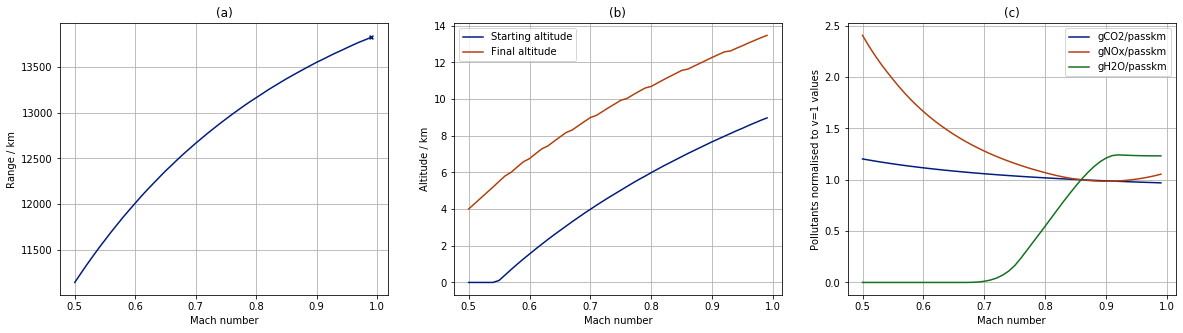

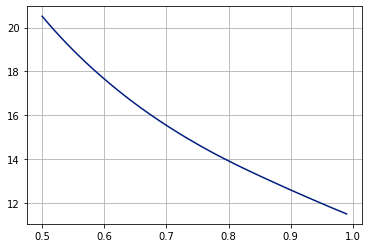

In [220]:
MRange = np.arange(0.5,1,0.01)

aircraftSpecs['vRat'] = 1.1

totDists = []
avgHs = []
gCO2PPKMs = []
gNOxPPKMs = []
gH2OPPKMs = []
startAlts = []
finalAlts = []
flightTimes = []

# Baseline figures at vRat = 1
hStart = findAlt4CruiseMach(vRat, 0.85)
timeData = simulateSteppedCruise(aircraftSpecs, hStart, 0.849, 0.1, suppressStats=True)
gCO2PPKM_base = timeData['gCO2PPKM']
gNOxPPKM_base = timeData['gNOxPPKM']
gH2OPPKM_base = timeData['gH2OPPKM']


plt.figure(figsize=[20,5])
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)

for M in MRange:
    hStart = findAlt4CruiseMach(vRat, M)
    timeData = simulateSteppedCruise(aircraftSpecs, hStart, M-0.01, 0.1, suppressStats=True)

    totDists.append(timeData['distances'][-1])
    avgHs.append(np.mean(timeData['Hs']))
    gCO2PPKMs.append(timeData['gCO2PPKM'] / gCO2PPKM_base)
    gNOxPPKMs.append(timeData['gNOxPPKM'] / gNOxPPKM_base)
    gH2OPPKMs.append(timeData['gH2OPPKM'] / gH2OPPKM_base)
    startAlts.append(timeData['altitudes'][0])
    finalAlts.append(timeData['altitudes'][-1])
    flightTimes.append(timeData['timeTo12000']/3600)


ax1.plot(MRange, totDists, label='Total distance travelled / km')
ax1.scatter(round(MRange[totDists.index(max(totDists))], 3), round(max(totDists), 3), marker='x', s=15)

ax1.set_title('(a)')
ax1.grid()
ax1.set_xlabel('Mach number')
ax1.set_ylabel('Range / km')

ax2.plot(MRange, startAlts, label='Starting altitude')
ax2.plot(MRange, finalAlts, label='Final altitude')

ax2.set_title('(b)')
ax2.legend()
ax2.grid()
ax2.set_xlabel('Mach number')
ax2.set_ylabel('Altitude / km')

ax3.plot(MRange, gCO2PPKMs, label='gCO2/passkm')
ax3.plot(MRange, gNOxPPKMs, label='gNOx/passkm')
ax3.plot(MRange, gH2OPPKMs, label='gH2O/passkm')

ax3.set_title('(c)')
ax3.legend()
ax3.grid()
ax3.set_xlabel('Mach number')
ax3.set_ylabel('Pollutants normalised to v=1 values')

plt.show()

plt.plot(MRange, flightTimes)
plt.grid()
plt.show()

aircraftSpecs['vRat'] = 1

# Emissions Reduction

Continuous climb cruise
v = 1.000 | Start altitude: 10.28 | Distance flown: 13639 km | CO2 pollution: 69.81 g/passkm | NOx pollution: 1.67 g/passkm | H2O contrail pollution: 32.12 g/passkm | Avg contrail chance = 39.83 % | Time to 12000: 13.28 hours | Number of iterations: 5432
10.28 12.822 0.848 0.8499
Reduced emissions cruise
v = 1.100 | Start altitude: 7.33 | Distance flown: 12968 km | CO2 pollution: 73.42 g/passkm | NOx pollution: 2.19 g/passkm | H2O contrail pollution: 5.25 g/passkm | Avg contrail chance = 8.30 % | Time to 12000: 14.55 hours | Number of iterations: 5669
7.33 10.009 0.7499 0.7499
Reduced emissions cruise with altitude limit
v = 1.100 | Start altitude: 7.33 | Distance flown: 12914 km | CO2 pollution: 73.73 g/passkm | NOx pollution: 2.22 g/passkm | H2O contrail pollution: 1.78 g/passkm | Avg contrail chance = 2.74 % | Time to 12000: 14.68 hours | Number of iterations: 5714
7.33 9 0.7499 0.6949


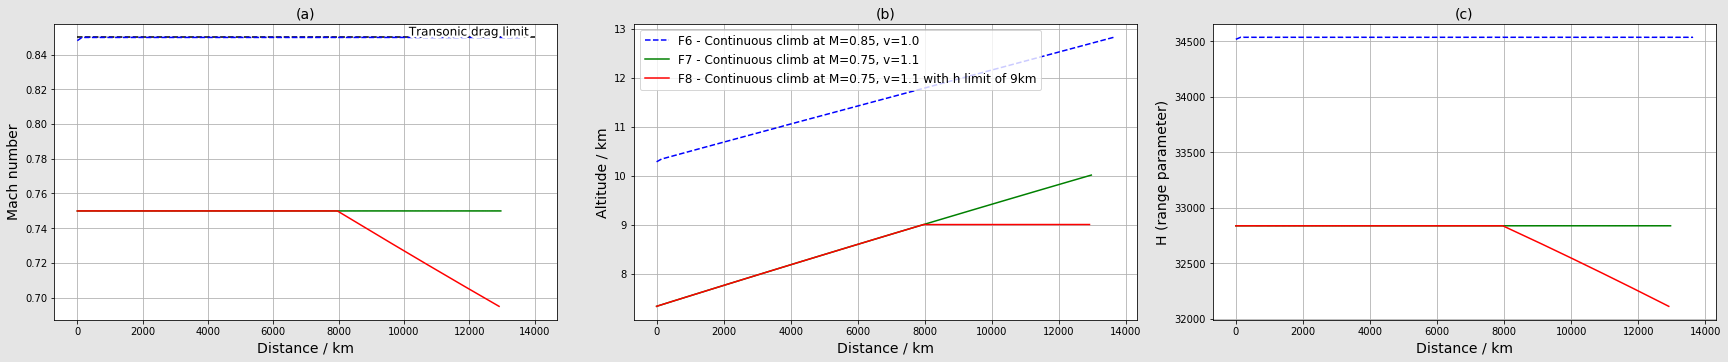

In [329]:
vRat = 1.1
M = 0.75

# Plot the Mach number following a speed ratio for different altitudes
fig = plt.figure(figsize=[24,5])
fig.set_facecolor('#E5E5E5')
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)


ax1.plot([0,14000],[0.85, 0.85], label='Transonic drag limit', color='black', linestyle='--')
lines = ax1.get_lines()
labelLines(lines, drop_label=True, align=True, xvals=[12000], yoffsets=[0.003], fontsize=12)

print('Continuous climb cruise')
hStart = findAlt4CruiseMach(1, 0.85)
timeData = simulateSteppedCruise(aircraftSpecs, hStart, 0.8499, 0.001)
print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))
ax1.plot(timeData['distances'], timeData['machs'], color='blue', linestyle='--')
ax2.plot(timeData['distances'], timeData['altitudes'], color='blue', linestyle='--', label='F6 - Continuous climb at M=0.85, v=1.0')
ax3.plot(timeData['distances'], timeData['Hs'], color='blue', linestyle='--')

print('Reduced emissions cruise')
hStart = findAlt4CruiseMach(vRat, M)
aircraftSpecs['vRat'] = vRat
timeData = simulateSteppedCruise(aircraftSpecs, hStart, M-0.0001, 0.001)
aircraftSpecs['vRat'] = 1
print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))
ax1.plot(timeData['distances'], timeData['machs'], color='green')
ax2.plot(timeData['distances'], timeData['altitudes'], color='green', label='F7 - Continuous climb at M=0.75, v=1.1')
ax3.plot(timeData['distances'], timeData['Hs'], color='green')

print('Reduced emissions cruise with altitude limit')
hStart = findAlt4CruiseMach(vRat, M)
aircraftSpecs['vRat'] = vRat
timeData = simulateSteppedCruise(aircraftSpecs, hStart, M-0.0001, 0.001, limitAlt=9)
aircraftSpecs['vRat'] = 1
print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))
ax1.plot(timeData['distances'], timeData['machs'], color='red')
ax2.plot(timeData['distances'], timeData['altitudes'], color='red', label='F8 - Continuous climb at M=0.75, v=1.1 with h limit of 9km')
ax3.plot(timeData['distances'], timeData['Hs'], color='red')

ax1.set_title('(a)', fontsize=14)
ax1.set_xlabel('Distance / km', fontsize=14)
ax1.set_ylabel('Mach number', fontsize=14)
ax1.grid()

ax2.set_title('(b)', fontsize=14)
ax2.set_xlabel('Distance / km', fontsize=14)
ax2.set_ylabel('Altitude / km', fontsize=14)
ax2.grid()
ax2.legend(fontsize=12, loc='upper left')

ax3.set_title('(c)', fontsize=14)
ax3.set_xlabel('Distance / km', fontsize=14)
ax3.set_ylabel('H (range parameter)', fontsize=14)
ax3.grid()

fig.tight_layout(pad=0.6)
plt.show()

# Split flights

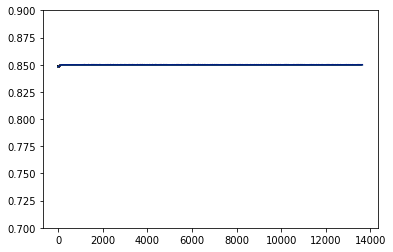

In [279]:
aircraftSpecs2 = aircraftSpecs.copy()
aircraftSpecs2['dontCheckW_P'] = True

fig = plt.figure(figsize=[6,4])

W_FRange = np.arange(10000,74001,100)

ranges = []

for W_F in W_FRange:
    W_E = ((0.3 + 1.0)*220000 - W_F) / (1 + 1)
    W_P = 220000 - W_E - W_F

    aircraftSpecs2['W_E'] = W_E
    aircraftSpecs2['W_P'] = W_P
    aircraftSpecs2['W_F'] = W_F

    hStart = findAlt4CruiseMach(1, 0.85, W_F=W_F, W_P=W_P, W_E=W_E)
    timeData = simulateSteppedCruise(aircraftSpecs2, hStart, 0.8499, 0.001, suppressStats=True)
    ranges.append(timeData['distances'][-1])
    plt.plot(timeData['distances'], timeData['machs'])

plt.ylim(0.7, 0.9)
plt.show()

40800 6564.436767845079


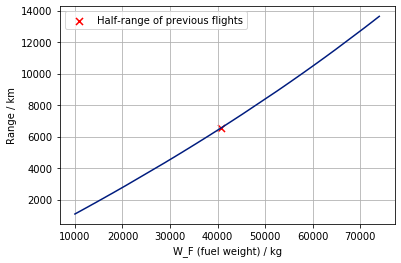

In [280]:
plt.figure(figsize=[6,4])
plt.plot(W_FRange, ranges)

idx6500 = np.where(np.round(np.array(ranges), -2)>6500)[0][0]
print(W_FRange[idx6500], ranges[idx6500])
plt.scatter(W_FRange[idx6500], ranges[idx6500], marker='x', color='red', s=50, label='Half-range of previous flights')

plt.xlabel('W_F (fuel weight) / kg')
plt.ylabel('Range / km')
plt.grid()
plt.legend()
plt.show()

Continuous climb cruise
v = 1.000 | Start altitude: 10.28 | Distance flown: 13639 km | CO2 pollution: 69.81 g/passkm | NOx pollution: 1.67 g/passkm | H2O contrail pollution: 32.12 g/passkm | Avg contrail chance = 39.83 % | Time to 12000: 13.28 hours | Number of iterations: 5432
10.28 12.822 0.848 0.8499
122600.0 40800 56600.0
220000.0
v = 1.000 | Start altitude: 10.28 | Distance flown: 6564 km | CO2 pollution: 79.99 g/passkm | NOx pollution: 1.95 g/passkm | H2O contrail pollution: 36.81 g/passkm | Avg contrail chance = 39.77 % | Time to 12000: 13.26 hours | Number of iterations: 2611
10.28 11.523 0.848 0.8499
13.255555555555556
Reduced emissions cruise with altitude limit
v = 1.100 | Start altitude: 7.33 | Distance flown: 12914 km | CO2 pollution: 73.73 g/passkm | NOx pollution: 2.22 g/passkm | H2O contrail pollution: 1.78 g/passkm | Avg contrail chance = 2.74 % | Time to 12000: 14.68 hours | Number of iterations: 5714
7.33 9 0.7499 0.6949
v = 1.100 | Start altitude: 7.33 | Distance fl

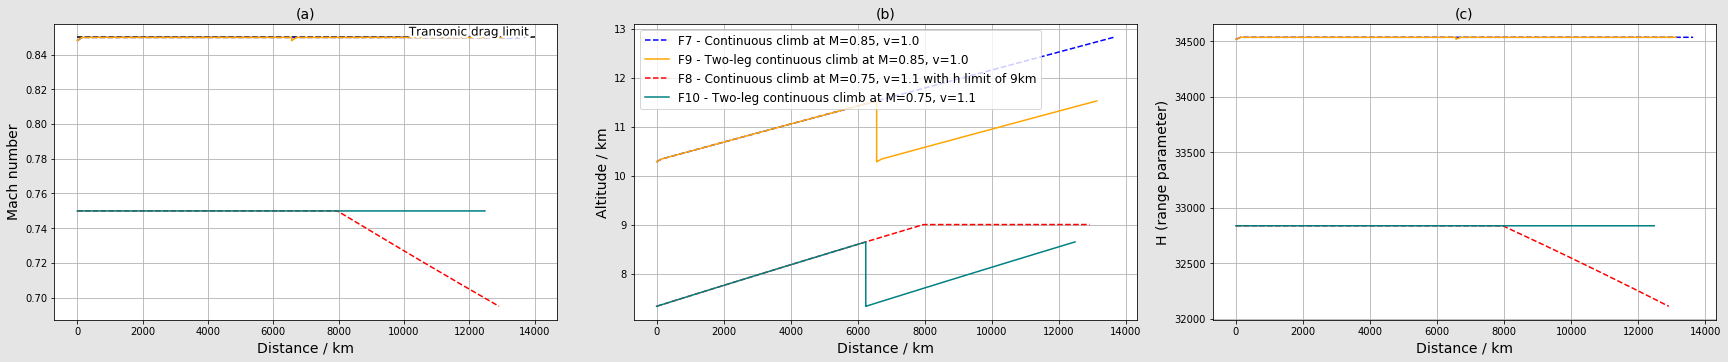

In [330]:
vRat = 1.1
M = 0.75

# Plot the Mach number following a speed ratio for different altitudes
fig = plt.figure(figsize=[24,5])
fig.set_facecolor('#E5E5E5')
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)


ax1.plot([0,14000],[0.85, 0.85], label='Transonic drag limit', color='black', linestyle='--')
lines = ax1.get_lines()
labelLines(lines, drop_label=True, align=True, xvals=[12000], yoffsets=[0.003], fontsize=12)


print('Continuous climb cruise')
hStart = findAlt4CruiseMach(1, 0.85)
timeData = simulateSteppedCruise(aircraftSpecs, hStart, 0.8499, 0.001)
print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))
ax1.plot(timeData['distances'], timeData['machs'], color='blue', linestyle='--')
ax2.plot(timeData['distances'], timeData['altitudes'], color='blue', linestyle='--', label='F7 - Continuous climb at M=0.85, v=1.0')
ax3.plot(timeData['distances'], timeData['Hs'], color='blue', linestyle='--')


W_F = W_FRange[idx6500]
W_E = ((0.3 + 1.0)*220000 - W_F) / (1 + 1)
W_P = 220000 - W_E - W_F

print(W_E, W_F, W_P)
print(W_E + W_F + W_P)

aircraftSpecs2['W_E'] = W_E
aircraftSpecs2['W_P'] = W_P
aircraftSpecs2['W_F'] = W_F

hStart = findAlt4CruiseMach(1, 0.85, W_F=W_F, W_P=W_P, W_E=W_E)
timeData = simulateSteppedCruise(aircraftSpecs2, hStart, 0.8499, 0.001)
print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))
actualTime12000 = timeData['times'][np.where(np.array(timeData['distances'])>6000)[0][0]] * 2 / 3600
print(actualTime12000)

newDistances = timeData['distances'] + [timeData['distances'][-1] + timeData['distances'][i] for i in range(len(timeData['distances']))]

ax1.plot(newDistances, timeData['machs']*2, color='orange')
ax2.plot(newDistances, timeData['altitudes']*2, color='orange', label='F9 - Two-leg continuous climb at M=0.85, v=1.0')
ax3.plot(newDistances, timeData['Hs']*2, color='orange')


print('Reduced emissions cruise with altitude limit')
hStart = findAlt4CruiseMach(vRat, M)
aircraftSpecs['vRat'] = vRat
timeData = simulateSteppedCruise(aircraftSpecs, hStart, M-0.0001, 0.001, limitAlt=9)
aircraftSpecs['vRat'] = 1
print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))
ax1.plot(timeData['distances'], timeData['machs'], color='red', linestyle='--')
ax2.plot(timeData['distances'], timeData['altitudes'], color='red', linestyle='--', label='F8 - Continuous climb at M=0.75, v=1.1 with h limit of 9km')
ax3.plot(timeData['distances'], timeData['Hs'], color='red', linestyle='--')


hStart = findAlt4CruiseMach(vRat, M, W_F=W_F, W_P=W_P, W_E=W_E)
aircraftSpecs2['vRat'] = vRat
timeData = simulateSteppedCruise(aircraftSpecs2, hStart, M-0.0001, 0.001, limitAlt=9)
aircraftSpecs2['vRat'] = 1
print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))
actualTime12000 = timeData['times'][np.where(np.array(timeData['distances'])>6000)[0][0]] * 2 / 3600
print(actualTime12000)

newDistances = timeData['distances'] + [timeData['distances'][-1] + timeData['distances'][i] for i in range(len(timeData['distances']))]

ax1.plot(newDistances, timeData['machs']*2, color='teal')
ax2.plot(newDistances, timeData['altitudes']*2, color='teal', label='F10 - Two-leg continuous climb at M=0.75, v=1.1')
ax3.plot(newDistances, timeData['Hs']*2, color='teal')


ax1.set_title('(a)', fontsize=14)
ax1.set_xlabel('Distance / km', fontsize=14)
ax1.set_ylabel('Mach number', fontsize=14)
ax1.grid()

ax2.set_title('(b)', fontsize=14)
ax2.set_xlabel('Distance / km', fontsize=14)
ax2.set_ylabel('Altitude / km', fontsize=14)
ax2.grid()
ax2.legend(fontsize=12, loc='upper left')

ax3.set_title('(c)', fontsize=14)
ax3.set_xlabel('Distance / km', fontsize=14)
ax3.set_ylabel('H (range parameter)', fontsize=14)
ax3.grid()

fig.tight_layout(pad=0.6)
plt.show()

# Overall Pressure Ratio

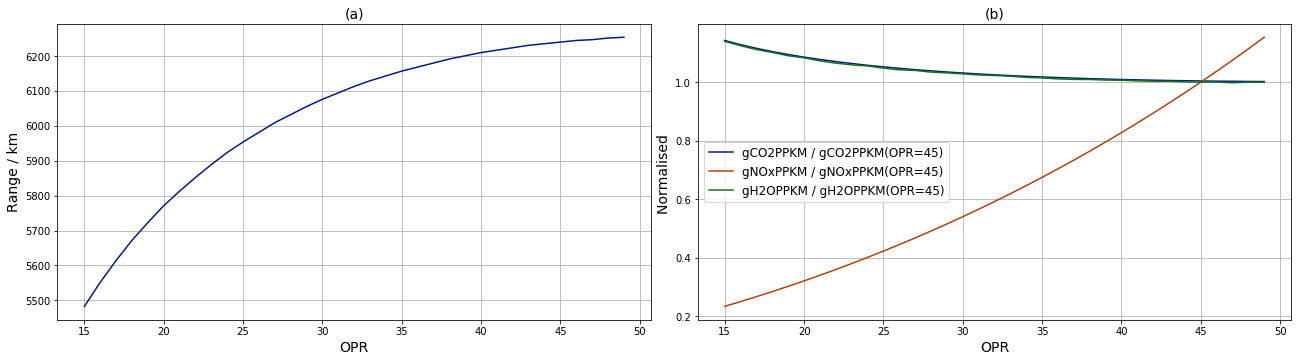

In [332]:
vRat = 1.1
M = 0.75

# Plot the Mach number following a speed ratio for different altitudes
fig = plt.figure(figsize=[18,5])
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)


hStart = findAlt4CruiseMach(vRat, M, W_F=W_F, W_P=W_P, W_E=W_E)
aircraftSpecs2['vRat'] = vRat

OPRRange = np.arange(15,50,1)
ranges = []
gCO2PPKMs = []
gNOxPPKMs = []
gH2OPPKMs = []

for OPR in OPRRange:
    aircraftSpecs2['rEgnine'] = OPR
    timeData = simulateSteppedCruise(aircraftSpecs2, hStart, M-0.0001, 0.001, limitAlt=9, suppressStats=True)

    ranges.append(timeData['distances'][-1])
    gCO2PPKMs.append(timeData['gCO2PPKM'])
    gNOxPPKMs.append(timeData['gNOxPPKM'])
    gH2OPPKMs.append(timeData['gH2OPPKM'])

aircraftSpecs2['rEngine'] = 45

ax1.plot(OPRRange, ranges)

gCO2PPKMs = np.array(gCO2PPKMs)/gCO2PPKMs[np.where(OPRRange==45)[0][0]] + 0.004
gNOxPPKMs = np.array(gNOxPPKMs)/gNOxPPKMs[np.where(OPRRange==45)[0][0]]
gH2OPPKMs = np.array(gH2OPPKMs)/gH2OPPKMs[np.where(OPRRange==45)[0][0]]

ax2.plot(OPRRange, gCO2PPKMs, label='gCO2PPKM / gCO2PPKM(OPR=45)')
ax2.plot(OPRRange, gNOxPPKMs, label='gNOxPPKM / gNOxPPKM(OPR=45)')
ax2.plot(OPRRange, gH2OPPKMs, label='gH2OPPKM / gH2OPPKM(OPR=45)')

ax1.set_title('(a)', fontsize=14)
ax1.set_xlabel('OPR', fontsize=14)
ax1.set_ylabel('Range / km', fontsize=14)
ax1.grid()

ax2.set_title('(b)', fontsize=14)
ax2.set_xlabel('OPR', fontsize=14)
ax2.set_ylabel('Normalised ', fontsize=14)
ax2.grid()
ax2.legend(fontsize=12, loc='center left')

fig.tight_layout(pad=0.6)
plt.show()

v = 1.100 | Start altitude: 7.33 | Distance flown: 6240 km | CO2 pollution: 84.13 g/passkm | NOx pollution: 2.75 g/passkm | H2O contrail pollution: 0.13 g/passkm | Avg contrail chance = 0.17 % | Time to 12000: 14.43 hours | Number of iterations: 2702
7.33 8.645 0.7499 0.7499
14.433333333333334
v = 1.100 | Start altitude: 7.33 | Distance flown: 6076 km | CO2 pollution: 86.42 g/passkm | NOx pollution: 1.49 g/passkm | H2O contrail pollution: 0.13 g/passkm | Avg contrail chance = 0.17 % | Time to 12000: 14.43 hours | Number of iterations: 2631
7.33 8.645 0.7499 0.7499
14.433333333333334
v = 1.100 | Start altitude: 7.33 | Distance flown: 5771 km | CO2 pollution: 90.99 g/passkm | NOx pollution: 0.88 g/passkm | H2O contrail pollution: 0.14 g/passkm | Avg contrail chance = 0.17 % | Time to 12000: 14.43 hours | Number of iterations: 2499
7.33 8.645 0.7499 0.7499
14.433333333333334


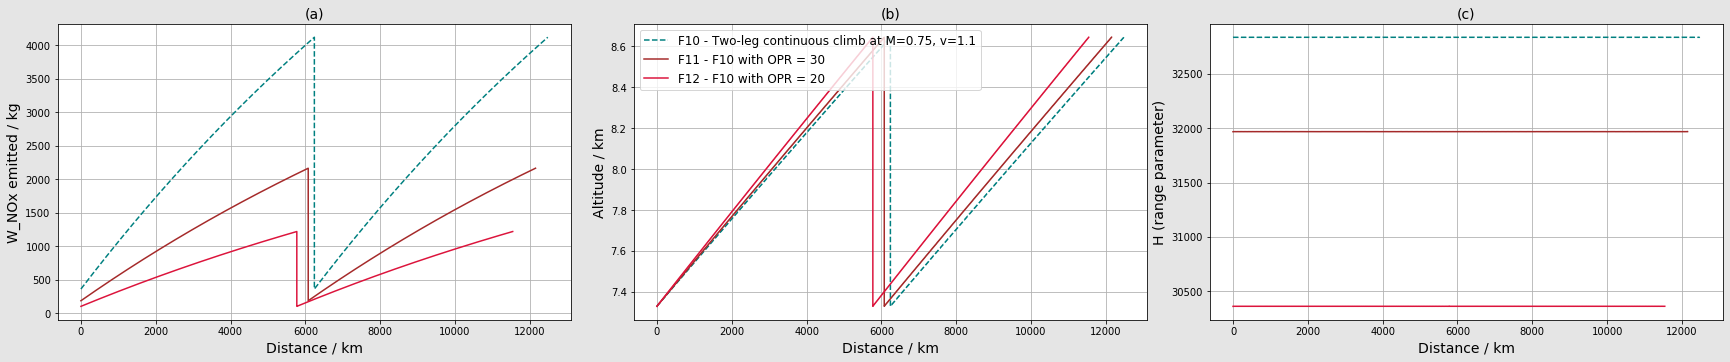

In [341]:
vRat = 1.1
M = 0.75
OPR = 30
OPR2 = 20

# Plot the Mach number following a speed ratio for different altitudes
fig = plt.figure(figsize=[24,5])
fig.set_facecolor('#E5E5E5')
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)


hStart = findAlt4CruiseMach(vRat, M, W_F=W_F, W_P=W_P, W_E=W_E)
aircraftSpecs2['vRat'] = vRat
timeData = simulateSteppedCruise(aircraftSpecs2, hStart, M-0.0001, 0.001, limitAlt=9)
aircraftSpecs2['vRat'] = 1
print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))
actualTime12000 = timeData['times'][np.where(np.array(timeData['distances'])>6000)[0][0]] * 2 / 3600
print(actualTime12000)

newDistances = timeData['distances'] + [timeData['distances'][-1] + timeData['distances'][i] for i in range(len(timeData['distances']))]

ax1.plot(newDistances, np.array(timeData['W_NOXs']*2)/1000, color='teal', linestyle='--')
ax2.plot(newDistances, timeData['altitudes']*2, color='teal', linestyle='--', label='F10 - Two-leg continuous climb at M=0.75, v=1.1')
ax3.plot(newDistances, timeData['Hs']*2, color='teal', linestyle='--')


hStart = findAlt4CruiseMach(vRat, M, W_F=W_F, W_P=W_P, W_E=W_E)
aircraftSpecs2['vRat'] = vRat
aircraftSpecs2['rEgnine'] = OPR
timeData = simulateSteppedCruise(aircraftSpecs2, hStart, M-0.0001, 0.001, limitAlt=9)
aircraftSpecs2['vRat'] = 1
aircraftSpecs2['rEgnine'] = 45
print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))
actualTime12000 = timeData['times'][np.where(np.array(timeData['distances'])>6000)[0][0]] * 2 / 3600
print(actualTime12000)

newDistances = timeData['distances'] + [timeData['distances'][-1] + timeData['distances'][i] for i in range(len(timeData['distances']))]

ax1.plot(newDistances, np.array(timeData['W_NOXs']*2)/1000, color='brown')
ax2.plot(newDistances, timeData['altitudes']*2, color='brown', label=f'F11 - F10 with OPR = {OPR}')
ax3.plot(newDistances, timeData['Hs']*2, color='brown')


hStart = findAlt4CruiseMach(vRat, M, W_F=W_F, W_P=W_P, W_E=W_E)
aircraftSpecs2['vRat'] = vRat
aircraftSpecs2['rEgnine'] = OPR2
timeData = simulateSteppedCruise(aircraftSpecs2, hStart, M-0.0001, 0.001, limitAlt=9)
aircraftSpecs2['vRat'] = 1
aircraftSpecs2['rEgnine'] = 45
print(round(timeData['altitudes'][0], 4), round(timeData['altitudes'][-1], 4), round(timeData['machs'][0], 4), round(timeData['machs'][-1], 4))
# actualTime12000 = timeData['times'][np.where(np.array(timeData['distances'])>6000)[0][0]] * 2 / 3600
print(actualTime12000)

newDistances = timeData['distances'] + [timeData['distances'][-1] + timeData['distances'][i] for i in range(len(timeData['distances']))]

ax1.plot(newDistances, np.array(timeData['W_NOXs']*2)/1000, color='crimson')
ax2.plot(newDistances, timeData['altitudes']*2, color='crimson', label=f'F12 - F10 with OPR = {OPR2}')
ax3.plot(newDistances, timeData['Hs']*2, color='crimson')


ax1.set_title('(a)', fontsize=14)
ax1.set_xlabel('Distance / km', fontsize=14)
ax1.set_ylabel('W_NOx emitted / kg', fontsize=14)
ax1.grid()

ax2.set_title('(b)', fontsize=14)
ax2.set_xlabel('Distance / km', fontsize=14)
ax2.set_ylabel('Altitude / km', fontsize=14)
ax2.grid()
ax2.legend(fontsize=12, loc='upper left')

ax3.set_title('(c)', fontsize=14)
ax3.set_xlabel('Distance / km', fontsize=14)
ax3.set_ylabel('H (range parameter)', fontsize=14)
ax3.grid()

fig.tight_layout(pad=0.6)
plt.show()

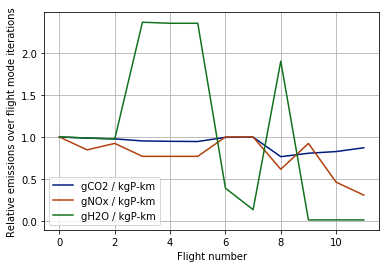

In [344]:
gCO2kgPkm = np.array([0.443,0.437,0.433,0.422,0.420,0.419,0.441,0.442,0.339,0.357,0.366,0.386])
gNOxkgPkm = np.array([0.013,0.011,0.012,0.010,0.010,0.010,0.013,0.013,0.008,0.012,0.006,0.004])
gH2OkgPkm = np.array([0.082,0.081,0.080,0.194,0.193,0.193,0.032,0.011,0.156,0.001,0.001,0.001])

gCO2kgPkm = gCO2kgPkm / gCO2kgPkm[0]
gNOxkgPkm = gNOxkgPkm / gNOxkgPkm[0]
gH2OkgPkm = gH2OkgPkm / gH2OkgPkm[0]

plt.figure(figsize=[6,4])

plt.plot(gCO2kgPkm, label='gCO2 / kgP-km')
plt.plot(gNOxkgPkm, label='gNOx / kgP-km')
plt.plot(gH2OkgPkm, label='gH2O(contrail) / kgP-km')

plt.xlabel('Flight number')
plt.ylabel('Relative emissions over flight mode iterations')

plt.legend()
plt.grid()
plt.show()